In [2]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
from typing import Union, Tuple
from util_detroit import csv_with_x_y_to_gpd

import re,os
import numpy as np
import matplotlib.pyplot as plt

import kml2geojson
import json

In [3]:
pd.options.display.max_columns = None

### S3 data pull

In [2]:
bucket = "s3://secondmeasure-dev-at-foundational-data/hakso/detroit/"
neighborhood_file = f"{bucket}Current_City_of_Detroit_Neighborhoods.geojson"
greenlight_file = f"{bucket}Project_Green_Light_Locations.geojson"

In [4]:
# neighborhood_geo_df = gpd.read_file(neighborhood_file)
# neighborhood_geo_df = gpd.read_file(neighborhood_file)
# greenlight_geo_df = gpd.read_file(greenlight_file)
greenlight_geo_df = gpd.read_file("Project_Green_Light_Locations.geojson")

In [11]:
greenlight_geo_df.notnull().sum()/greenlight_geo_df.shape[0]

address          1.0
business_name    1.0
business_type    1.0
precinct         1.0
live_date        1.0
ObjectId         1.0
geometry         1.0
dtype: float64

In [4]:
neighborhood_geo_df.head()

,OBJECTID,council_district,nhood_num,nhood_name,Website,geometry
0,1,4,103,West End,https://theneighborhoods.org/neighborhoods/wes...,"POLYGON ((-82.99152 42.38439, -82.99249 42.384..."
1,2,4,105,Chandler Park,https://theneighborhoods.org/neighborhoods/cha...,"POLYGON ((-82.97585 42.38933, -82.97603 42.389..."
2,3,4,100,Riverbend,https://theneighborhoods.org/neighborhoods/riv...,"POLYGON ((-82.96784 42.38369, -82.96783 42.383..."
3,4,4,101,Jefferson Chalmers,https://theneighborhoods.org/neighborhoods/jef...,"POLYGON ((-82.95141 42.35503, -82.95292 42.354..."
4,5,1,29,Riverdale,https://theneighborhoods.org/neighborhoods/riv...,"POLYGON ((-83.25748 42.41460, -83.25729 42.411..."


In [9]:
greenlight_geo_df.head()

,address,business_name,business_type,precinct,live_date,ObjectId,geometry
0,15510 Fenkell St,Mobil,Retail,8,2016-01-01T05:00:00+00:00,1,POINT (-83.19918 42.40172)
1,8930 W McNichols Rd,Marathon,Retail,12,2016-01-01T05:00:00+00:00,2,POINT (-83.15984 42.41718)
2,15439 Schoolcraft Ave,Citgo,Retail,2,2016-01-01T05:00:00+00:00,3,POINT (-83.19764 42.38679)
3,11603 E 7 Mile Rd,Sunoco,Retail,9,2016-01-01T05:00:00+00:00,4,POINT (-83.00422 42.43468)
4,10601 E Outer Dr,BP,Retail,9,2016-01-01T05:00:00+00:00,5,POINT (-82.95968 42.40584)


### Data Verification

##### Empty and NaN check

In [6]:
print(neighborhood_geo_df['geometry'].is_empty.sum())
print(greenlight_geo_df['geometry'].is_empty.sum())
print(neighborhood_geo_df['geometry'].isna().sum())
print(greenlight_geo_df['geometry'].isna().sum())

0
0
0
0


In [7]:
#greenlight_geo_df['geometry'][1] = np.NaN

### Map locations to neighborhoods

<AxesSubplot:>

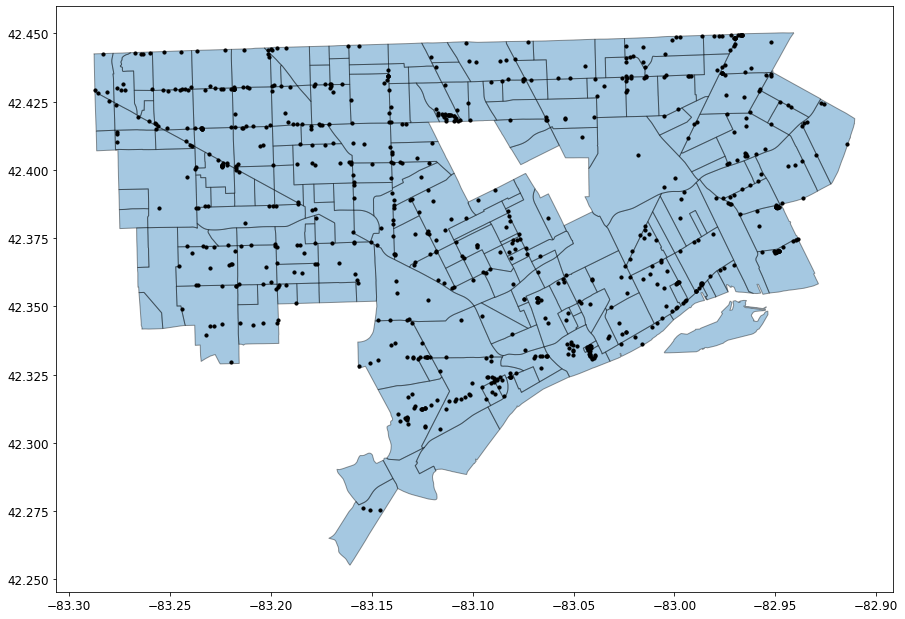

In [8]:
fig,ax = plt.subplots(figsize = (15,15))
neighborhood_geo_df.plot(ax = ax, alpha=0.4, edgecolor='black')
greenlight_geo_df.plot(ax = ax, markersize=10, color = "black")

### Greenlight Data Exploration

In [9]:
greenlight_geo_df.head()

,address,business_name,business_type,precinct,live_date,ObjectId,geometry
0,15510 Fenkell St,Mobil,Retail,8,2016-01-01T05:00:00+00:00,1,POINT (-83.19918 42.40172)
1,8930 W McNichols Rd,Marathon,Retail,12,2016-01-01T05:00:00+00:00,2,POINT (-83.15984 42.41718)
2,15439 Schoolcraft Ave,Citgo,Retail,2,2016-01-01T05:00:00+00:00,3,POINT (-83.19764 42.38679)
3,11603 E 7 Mile Rd,Sunoco,Retail,9,2016-01-01T05:00:00+00:00,4,POINT (-83.00422 42.43468)
4,10601 E Outer Dr,BP,Retail,9,2016-01-01T05:00:00+00:00,5,POINT (-82.95968 42.40584)


#### Distance calculation

In [12]:
tmp = greenlight_geo_df

In [10]:
from scipy.spatial import KDTree

In [77]:
def nearest_neighbor(a_df: pd.DataFrame, b_df: pd.DataFrame, target_nearness_rank: int=1, return_all_cols=False) -> pd.DataFrame:
    """return nearest point in B to each point in A
        
    both a_df and b_df must have a column called geometry with geopandas point values
    """
    
#     get coordinates for each
    locations_a = np.array(list(a_df.geometry.apply(lambda x: (x.x, x.y))))
    locations_b = np.array(list(b_df.geometry.apply(lambda x: (x.x, x.y))))
#     generate nearest neighbor lookup tree for point in B
    b_locations_map = KDTree(locations_b)
#     calculate the nearest point in B for every A
    dist_to_nearest_match, idx_in_b = b_locations_map.query(locations_a, k=[target_nearness_rank])
    if return_all_cols:
        b_nearest = b_df.iloc[idx_in_b.flatten()].drop(columns="geometry")
        b_nearest.columns = [str(col) + '_neighbor' for col in b_nearest.columns]
        gdf = pd.concat(
            [
                a_df.reset_index(drop=True),
                b_nearest.reset_index(drop=True),
                pd.Series(dist_to_nearest_match.flatten()*111139, name='meters_to_nearest_match')
            ], 
            axis=1)
        return gdf
    else:
        return a_df.assign(meters_to_nearest_match=dist_to_nearest_match*111139, idx_in_b=idx_in_b)

In [78]:
greenlight_geo_df = tmp
# greenlight_geo_df = nearest_neighbor(greenlight_geo_df, greenlight_geo_df, 2, True)
greenlight_geo_df = nearest_neighbor(greenlight_geo_df, greenlight_geo_df, 2, False)

In [79]:
greenlight_geo_df

,address,business_name,business_type,precinct,live_date,ObjectId,geometry,meters_to_nearest_match,idx_in_b
0,15510 Fenkell St,Mobil,Retail,8,2016-01-01T05:00:00+00:00,1,POINT (-83.19918 42.40172),985.472089,210
1,8930 W McNichols Rd,Marathon,Retail,12,2016-01-01T05:00:00+00:00,2,POINT (-83.15984 42.41718),813.165087,380
2,15439 Schoolcraft Ave,Citgo,Retail,2,2016-01-01T05:00:00+00:00,3,POINT (-83.19764 42.38679),137.496237,343
3,11603 E 7 Mile Rd,Sunoco,Retail,9,2016-01-01T05:00:00+00:00,4,POINT (-83.00422 42.43468),132.460997,695
4,10601 E Outer Dr,BP,Retail,9,2016-01-01T05:00:00+00:00,5,POINT (-82.95968 42.40584),484.327007,311
...,...,...,...,...,...,...,...,...,...
762,825 Whitmore Rd,825 Whitmore,Residential,12,2021-07-27T04:00:00+00:00,763,POINT (-83.11406 42.41945),94.257601,761
763,595 Chene St,Martin Luther King I and II,Residential,7,2021-07-30T04:00:00+00:00,764,POINT (-83.02575 42.33981),222.095397,138
764,675 Seward St,Seward Apartments,Residential,3,2021-08-04T04:00:00+00:00,765,POINT (-83.08062 42.37323),116.873176,615
765,1310 Pallister St,Lexington Village,Residential,10,2021-08-05T04:00:00+00:00,766,POINT (-83.08633 42.36995),453.124665,570


In [84]:
greenlight_geo_df.sort_values('meters_to_nearest_match', ascending=True)

,address,business_name,business_type,precinct,live_date,ObjectId,geometry,meters_to_nearest_match,idx_in_b
330,8701 W Vernor Hwy,WAY Academy,Services,4,2018-07-30T04:00:00+00:00,331,POINT (-83.13271 42.30904),0.000000,274
329,"8701 W Vernor Hwy, Suite 301",Living Arts,Services,4,2018-07-30T04:00:00+00:00,330,POINT (-83.13271 42.30904),0.000000,274
274,"8701 W Vernor Hwy, Suite 102",COMPAS,Services,4,2018-04-04T04:00:00+00:00,275,POINT (-83.13271 42.30904),0.000000,274
589,"8044 Kercheval St, Unit 1A",Village Parlor,Services,7,2019-10-30T04:00:00+00:00,590,POINT (-82.99895 42.35853),2.688094,423
423,"8044 Kercheval, Unit 1B",Marrow,Retail,7,2018-12-07T05:00:00+00:00,424,POINT (-82.99892 42.35854),2.688094,589
...,...,...,...,...,...,...,...,...,...
168,18430 Ford Rd,Wendy's,Retail,6,2017-07-26T04:00:00+00:00,169,POINT (-83.21972 42.32946),1640.696876,571
714,1900 E McNichols Rd,BP,Retail,11,2021-02-05T05:00:00+00:00,715,POINT (-83.08162 42.41821),1658.786029,265
101,18201 Mack Ave,McDonald's,Retail,5,2017-03-20T04:00:00+00:00,102,POINT (-82.91449 42.40945),1766.757845,480
500,8301 Lynch Rd,Premier Group Associates,Services,11,2019-05-10T04:00:00+00:00,501,POINT (-83.01791 42.40532),1911.505005,508
